In [1]:
!git clone https://github.com/Nerdward/Hamoye_capstone_project_smote.git

Cloning into 'Hamoye_capstone_project_smote'...
remote: Enumerating objects: 10807, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 10807 (delta 9), reused 29 (delta 6), pack-reused 10768
Receiving objects: 100% (10807/10807), 360.00 MiB | 34.22 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Checking out files: 100% (10810/10810), done.


In [2]:
import tensorflow as tf
import keras.backend as K

#Import the inception model
from tensorflow.keras.applications import InceptionV3 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
base_model = InceptionV3(include_top=False,
                         input_shape=(299, 299, 3),
                         weights='imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

In [5]:
train_dataset = image_dataset_from_directory('/content/Hamoye_capstone_project_smote/Data/train',
                                             label_mode='categorical',
                                             shuffle=True,
                                             image_size=(299,299))

validation_dataset = image_dataset_from_directory('/content/Hamoye_capstone_project_smote/Data/val',
                                             label_mode='categorical',
                                           shuffle=True,
                                             image_size=(299,299))

Found 7556 files belonging to 4 classes.
Found 2160 files belonging to 4 classes.


In [6]:
base_model.trainable = False

In [7]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [8]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [9]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
# x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(4, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [10]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:

class EarlyStoppingAtMinLoss(tf.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_get_f1")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [12]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', get_f1])

In [13]:
initial_epochs = 10

loss0, accuracy0, geet_f1 = model.evaluate(validation_dataset)

68/68 [==============================] - 36s 312ms/step - loss: 1.5482 - accuracy: 0.2338 - get_f1: 0.3443


In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_get_f1', patience=2,
                                            mode='max', restore_best_weights=True)

In [17]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[callback])

Epoch 1/10
237/237 [==============================] - 87s 366ms/step - loss: 0.0241 - accuracy: 0.9938 - get_f1: 0.9865 - val_loss: 0.0174 - val_accuracy: 0.9935 - val_get_f1: 0.9900
Epoch 2/10
237/237 [==============================] - 87s 367ms/step - loss: 0.0188 - accuracy: 0.9951 - get_f1: 0.9877 - val_loss: 0.0147 - val_accuracy: 0.9949 - val_get_f1: 0.9920
Epoch 3/10
237/237 [==============================] - 88s 368ms/step - loss: 0.0154 - accuracy: 0.9963 - get_f1: 0.9896 - val_loss: 0.0133 - val_accuracy: 0.9958 - val_get_f1: 0.9934
Epoch 4/10
237/237 [==============================] - 87s 367ms/step - loss: 0.0130 - accuracy: 0.9972 - get_f1: 0.9914 - val_loss: 0.0139 - val_accuracy: 0.9944 - val_get_f1: 0.9911
Epoch 5/10
237/237 [==============================] - 87s 367ms/step - loss: 0.0122 - accuracy: 0.9970 - get_f1: 0.9907 - val_loss: 0.0126 - val_accuracy: 0.9944 - val_get_f1: 0.9918


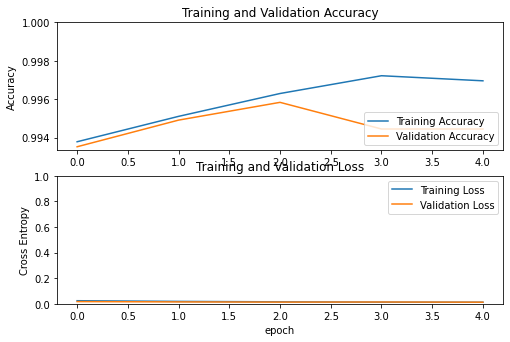

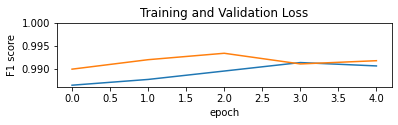

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']

plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

plt.subplot(3, 1, 3)
plt.plot(f1, label='Training f1')
plt.plot(val_f1, label='Validation f1')
plt.ylabel('F1 score')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
test_dataset = image_dataset_from_directory('/content/Hamoye_capstone_project_smote/Data/test',
                                             label_mode='categorical',
                                           shuffle=True,
                                             image_size=(299,299))

Found 1084 files belonging to 4 classes.


In [20]:
model.evaluate(test_dataset)

34/34 [==============================] - 13s 370ms/step - loss: 0.0159 - accuracy: 0.9972 - get_f1: 0.9908


[0.015923071652650833, 0.9972324967384338, 0.9908355474472046]

In [21]:
model.save_weights('inceptionv3weights.h5')

In [26]:
# loading library
import pickle

In [27]:
with open('inceptionv3_pkl', 'wb') as files:
    pickle.dump(model, files)

INFO:tensorflow:Assets written to: ram://d46b06e6-9455-4722-be3d-1b673f32db47/assets
